# Bayesian Optimization

*Bayesian optimization* proceeds by maintaining a probabilistic belief about $f(x)$ and designing a so-called acquisition function to determine where to evaluate the function next.  Bayesian optimization is particularly well-suited to global optimization problems where $f$ is an expensive black-box function; for example, evaluating $f$ might require running an expensive simulation. Bayesian optimization has recently become popular for training expensive machine-learning models whose behavior depend in a complicated way on their parameters (e.g., convolutional neural networks).

The meta-approach in Bayesian optimization is to design an **acquisition function** $a(x)$. The acquisition function is typically an inexpensive function that can be evaluated at a given point that is commensurate with how desirable evaluating $f(x)$ at $x$ is expected to be for the minimization problem.

**Surrogate Model:** Bayesian optimization uses a surrogate model, often a Gaussian Process (GP), to approximate the objective function (e.g., model accuracy) that you're trying to optimize.

**Exploration and Exploitation:**
It balances exploration (trying new hyperparameter combinations) and exploitation (focusing on promising regions of the hyperparameter space).

**Acquisition Function:**
An acquisition function guides the search, suggesting the next hyperparameter combination to evaluate based on the surrogate model's predictions and uncertainty.

**Iterative Process:**
The process iteratively evaluates models with different hyperparameters, updates the surrogate model, and uses the updated model to suggest the next set of hyperparameters to try.

## Why Use Bayesian Optimization for CNN Hyperparameters?

**Efficiency:**
It can find good hyperparameter settings with fewer evaluations than grid search or random search.

**Handles Expensive Evaluations:** It's well-suited for models where training and evaluation are computationally expensive, as it learns from past evaluations to guide future searches.

**Intelligent Search:** It intelligently explores the hyperparameter space, focusing on regions that are likely to yield better results.

**Automated Tuning:** It can automate the hyperparameter tuning process, freeing up time for other tasks.

## Key Hyperparameters for CNNs to Tune with Bayesian Optimization:

**Learning Rate:** Controls how much the model adjusts to each training example.

**Batch Size:** The number of training examples used in each iteration.

**Dropout Rate:** The probability of randomly dropping out neurons during training.

**Number of Layers:** The number of convolutional or fully connected layers in the network.

**Number of Neurons:** The number of neurons in each layer.

**Activation Functions:** The functions used to introduce non-linearity into the network.

**Optimizer:** The algorithm used to update the model's weights.



## Example 1: Cancer Dataset - Classification using Support Vector Classifier (SVC)

In [1]:
# !pip install bayesian-optimization==1.4.1
# !pip install GPyOpt

# Then restart session.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from bayes_opt import BayesianOptimization, UtilityFunction
import warnings
warnings.filterwarnings("ignore")


In [3]:
!kaggle datasets download yasserh/breast-cancer-dataset
!unzip breast-cancer-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset
License(s): CC0-1.0
  0% 0.00/48.6k [00:00<?, ?B/s]
100% 48.6k/48.6k [00:00<00:00, 41.3MB/s]
Archive:  breast-cancer-dataset.zip
  inflating: breast-cancer.csv       


In [4]:
cancer = pd.read_csv("/content/breast-cancer.csv")
cancer.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
cancer.drop(columns="id", inplace=True)
cancer['diagnosis'] = cancer['diagnosis'].map({'M':1, 'B':0})
cancer.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [6]:
# Prepare the data.
X = cancer.drop(columns="diagnosis")
y = cancer["diagnosis"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                            stratify = y,
                                            random_state = 42)


In [8]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# Define the black box function to optimize.
def black_box_function(C):
    # C: SVC hyper parameter to optimize for.
    model = SVC(C = C)
    model.fit(X_train_scaled, y_train)
    y_score = model.decision_function(X_test_scaled)
    f = roc_auc_score(y_test, y_score)
    return f

Set range of C to optimize for. `bayes_opt` requires this to be a dictionary.

In [10]:
pbounds = {"C": [0.1, 10]}

Create a `BayesianOptimization` optimizer and optimize the given black_box_function.

In [11]:
optimizer = BayesianOptimization(f = black_box_function,
                                 pbounds = pbounds, verbose = 2,
                                 random_state = 4)
optimizer.maximize(init_points = 5, n_iter = 45)
print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))

|   iter    |  target   |     C     |
-------------------------------------
| 1         | 0.9945    | 9.674     |
| 2         | 0.9958    | 5.518     |
| 3         | 0.9945    | 9.73      |
| 4         | 0.9948    | 7.177     |
| 5         | 0.995     | 7.008     |
| 6         | 0.9964    | 4.563     |
| 7         | 0.9969    | 3.341     |
| 8         | 0.9966    | 1.418     |
| 9         | 0.9962    | 0.1       |
| 10        | 0.9971    | 2.43      |
| 11        | 0.9971    | 2.768     |
| 12        | 0.9971    | 2.596     |
| 13        | 0.9969    | 2.081     |
| 14        | 0.9971    | 2.978     |
| 15        | 0.9977    | 0.8112    |
| 16        | 0.9979    | 0.6423    |
| 17        | 0.9981    | 0.5536    |
| 18        | 0.9981    | 0.5536    |
| 19        | 0.9943    | 8.424     |
| 20        | 0.9966    | 3.964     |
| 21        | 0.9954    | 6.2       |
| 22        | 0.9981    | 0.4291    |
| 23        | 0.9981    | 0.4876    |
| 24        | 0.9964    | 5.011     |
| 25        

## Another method using the `UtilityFunction()` instance

Create the `optimizer`. The black box function to optimize is not specified here, as we will call that function directly later on.

In [12]:
optimizer = BayesianOptimization(f = None,
                                 pbounds = {"C": [0.01, 10],
                                            "degree": [1, 5]},
                                 verbose = 2, random_state = 1234)

Specify the acquisition function (`bayes_opt` uses the term utility function) to be the upper confidence bounds "`ucb`".
We set `kappa = 1.96` to balance exploration vs exploitation.
`xi = 0.01` is another hyperparameter which is required in the
arguments, but is not used by "`ucb`". Other acquisition functions
such as the expected improvement "`ei`" will be affected by `xi`.

In [13]:
utility = UtilityFunction(kind = "ucb", kappa = 1.96, xi = 0.01)  # Acquisition Function

We want to optimize both `C` and `degree` simultaneously.

In [14]:
def black_box_function(C, degree):
    model = SVC(C = C, degree = degree)
    model.fit(X_train_scaled, y_train)
    y_score = model.decision_function(X_test_scaled)
    f = roc_auc_score(y_test, y_score)
    return f

In [15]:
# Optimization for loop.
for i in range(25):
    # Get optimizer to suggest new parameter values to try using the
    # specified acquisition function.
    next_point = optimizer.suggest(utility)
    # Force degree from float to int.
    next_point["degree"] = int(next_point["degree"])
    # Evaluate the output of the black_box_function using
    # the new parameter values.
    target = black_box_function(**next_point)
    try:
        # Update the optimizer with the evaluation results.
        # This should be in try-except to catch any errors!
        optimizer.register(params = next_point, target = target)
    except:
        pass

Best result: {'C': 0.77561051651283, 'degree': 5.0}; f(x) = 0.998.


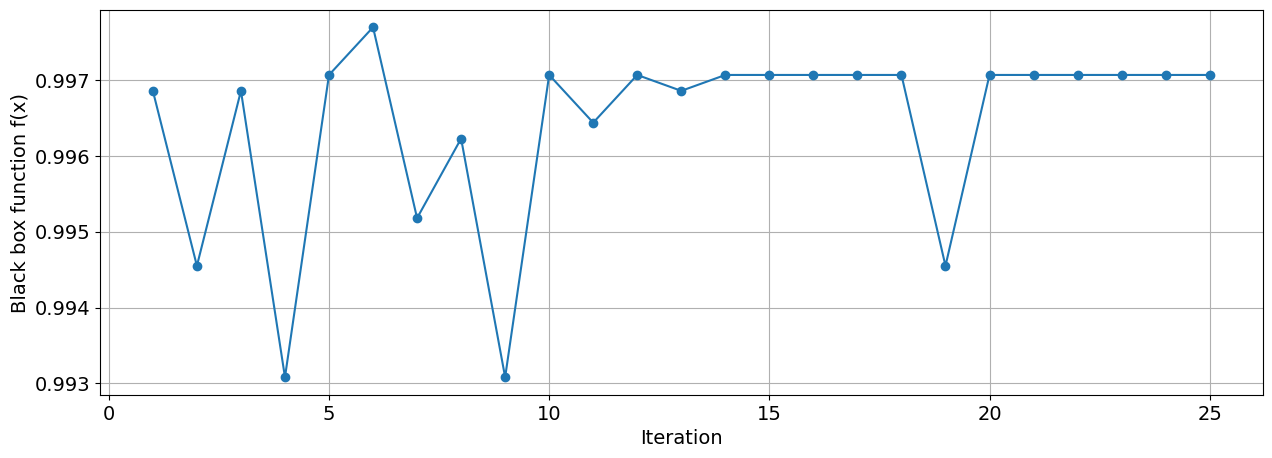

In [16]:
print("Best result: {}; f(x) = {:.3f}.".format(optimizer.max["params"], optimizer.max["target"]))
plt.figure(figsize = (15, 5))
plt.plot(range(1, 1 + len(optimizer.space.target)), optimizer.space.target, "-o")
plt.grid(True)
plt.xlabel("Iteration", fontsize = 14)
plt.ylabel("Black box function f(x)", fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [17]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
from hyperopt import fmin, tpe, Trials, hp, STATUS_OK

## Example 2: Create a random `n-class` classification problem.

* `n_features` is the total number of features
* `n_informative` is the number of informative features
* `n_features - n_informative` is number of non-informative features
* `n_redundant` features are generated as random linear combinations of the informative features

In [18]:
X_train, y_train = make_classification(n_samples=2500, n_features=20, n_informative=7, n_redundant=3)

In [19]:
X_train.shape, y_train.shape, X_train[0], y_train[0]

((2500, 20),
 (2500,),
 array([ 0.21921267, -0.89697672,  0.48806928, -0.54881178, -1.39595415,
         2.24391083,  1.43515948, -0.13734119, -1.57559911, -0.54821361,
         2.66920274, -0.24735536,  0.44933793,  1.1551927 , -0.9034122 ,
         0.67882448, -1.85741759,  1.29369751, -0.7064839 ,  1.14057646]),
 1)

In [20]:
def objective(args):

    '''Define the loss function / objective of our model.

    We will be using an SVM parameterized by the regularization parameter C
    and the parameter gamma.

    The C parameter trades off correct classification of training examples
    against maximization of the decision function's margin. For larger values
    of C, a smaller margin will be accepted.

    The gamma parameter defines how far the influence of a single training
    example reaches, with larger values meaning 'close'.
    '''
    C, gamma = args
    model = SVC(C=10 ** C, gamma=10 ** gamma, random_state=12345)
    loss = 1 - cross_val_score(estimator=model, X=X_train, y=y_train, scoring='roc_auc', cv=3).mean()
    return {'params': {'C': C, 'gamma': gamma}, 'loss': loss, 'status': STATUS_OK }


In [21]:
trials = Trials()
best = fmin(objective,
    space=[hp.uniform('C', -4., 1.), hp.uniform('gamma', -4., 1.)],
    algo=tpe.suggest,
    max_evals=1000,
    trials=trials)

100%|██████████| 1000/1000 [08:19<00:00,  2.00trial/s, best loss: 0.02633908239621041]


In [23]:
# Extract the loss for every combination of C, gamma
results = trials.results
ar = np.zeros(shape=(1000,3))
for i, r in enumerate(results):
    C = r['params']['C']
    gamma = r['params']['gamma']
    loss = r['loss']
    ar[i] = C, gamma, loss

ar

array([[-1.1320499 ,  0.82542598,  0.49840127],
       [ 0.31277582, -2.4893202 ,  0.04704861],
       [-1.49402942, -2.33768574,  0.09978103],
       ...,
       [ 0.99884634, -1.45378029,  0.03391289],
       [ 0.68727568, -1.9179709 ,  0.02654664],
       [ 0.14053849, -1.2279406 ,  0.0328124 ]])

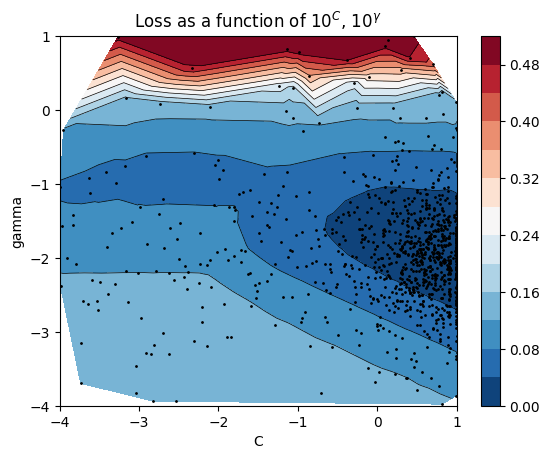

In [24]:
C, gamma, loss = ar[:, 0], ar[:, 1], ar[:, 2]

fig, ax = plt.subplots(nrows=1)
ax.tricontour(C, gamma, loss, levels=14, linewidths=0.5, colors='k')
cntr = ax.tricontourf(C, gamma, loss, levels=14, cmap="RdBu_r")

fig.colorbar(cntr, ax=ax)
ax.plot(C, gamma, 'ko', ms=1)
ax.set(xlim=(-4, 1), ylim=(-4, 1))
plt.title('Loss as a function of $10^C$, $10^\gamma$')
plt.xlabel('C')
plt.ylabel('gamma')

plt.show()

## Example 3: Bayesian Optimization of a CNN

In [25]:
import GPyOpt
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [26]:
iris = load_iris()
X, y = iris.data, iris.target

In [27]:
label_encoder = LabelEncoder()
y_binary = label_encoder.fit_transform(y)
y_binary = (y_binary == 0).astype(int)

In [28]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y_binary, test_size=0.2, random_state=42)

In [29]:
def objective_function(params):
    learning_rate, num_units, dropout_rate, l2_reg, batch_size = params[0]

    # Ensure num_units and batch_size are integers
    num_units = int(num_units)
    batch_size = int(batch_size)

    model = Sequential()
    model.add(Dense(num_units, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid',
              kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))

    optimizer = Adam(learning_rate)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy', metrics=['accuracy'])

    checkpoint_path = f"checkpoint_lr{learning_rate}_nu{num_units}_dr{dropout_rate}_l2{l2_reg}_bs{batch_size}.keras"
    checkpoint = ModelCheckpoint(
        checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max')
    early_stopping = EarlyStopping(
        monitor='val_accuracy', patience=5, mode='max')

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=100, batch_size=batch_size, callbacks=[checkpoint, early_stopping])

    return max(history.history['val_accuracy'])


In [30]:
bounds = [
    {'name': 'learning_rate', 'type': 'continuous', 'domain': (0.001, 0.1)},
    {'name': 'num_units', 'type': 'discrete', 'domain': (16, 32, 64, 128)},
    {'name': 'dropout_rate', 'type': 'continuous', 'domain': (0.1, 0.5)},
    {'name': 'l2_reg', 'type': 'continuous', 'domain': (0.001, 0.1)},
    {'name': 'batch_size', 'type': 'discrete', 'domain': (32, 64, 128)}
]

In [31]:
optimizer = GPyOpt.methods.BayesianOptimization(
    f=objective_function, domain=bounds)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6250 - loss: 0.6894 - val_accuracy: 0.6667 - val_loss: 0.5615
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.6667 - loss: 0.5850 - val_accuracy: 0.6667 - val_loss: 0.3717
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.7000 - loss: 0.3850 - val_accuracy: 1.0000 - val_loss: 0.2704
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9833 - loss: 0.2954 - val_accuracy: 1.0000 - val_loss: 0.2272
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.2435 - val_accuracy: 1.0000 - val_loss: 0.1643
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 0.1842 - val_accuracy: 1.0000 - val_loss: 0.1273
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 1.0000 - loss: 0.1478 - val_accuracy: 1.0000 - val_loss: 0.1153
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 0.1195 - val_accuracy: 1.0000 - val_los

In [32]:
optimizer.run_optimization(max_iter=30, report_file='bayes_opt.txt')


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.4171 - loss: 1.7823 - val_accuracy: 0.8333 - val_loss: 0.5979
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7719 - loss: 0.6090 - val_accuracy: 0.6667 - val_loss: 0.3726
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8015 - loss: 0.3558 - val_accuracy: 1.0000 - val_loss: 0.1859
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9915 - loss: 0.1928 - val_accuracy: 1.0000 - val_loss: 0.1396
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.1552 - val_accuracy: 1.0000 - val_loss: 0.1314
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9915 - loss: 0.1401 - val_accuracy: 1.0000 - val_loss: 0.1134
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.1236 - val_accuracy: 1.0000 - val_loss: 0.1001
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9852 - loss: 0.1147 - val_accuracy: 1.0000 - val_loss

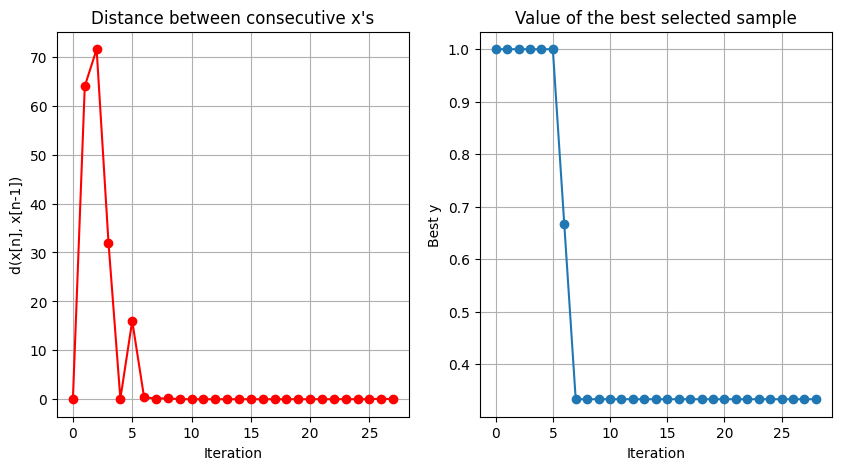

In [33]:
optimizer.plot_convergence()

Bayesian optimization treats hyperparameter tuning like a **regression problem**. Given a set of input features (the hyperparameters), hyperparameter tuning optimizes a model for the metric that you choose. To solve a regression problem, hyperparameter tuning makes guesses about which hyperparameter combinations are likely to get the best results. It then runs training jobs to test these values. After testing a set of hyperparameter values, hyperparameter tuning uses regression to choose the next set of hyperparameter values to test.

Hyperparameter tuning uses an Amazon SageMaker AI implementation of Bayesian optimization.

When choosing the best hyperparameters for the next training job, hyperparameter tuning considers everything that it knows about this problem so far. Sometimes it chooses a combination of hyperparameter values close to the combination that resulted in the best previous training job to incrementally improve performance. This allows hyperparameter tuning to use the best known results. Other times, it chooses a set of hyperparameter values far removed from those it has tried. This allows it to explore the range of hyperparameter values to try to find new areas that are not yet well understood. The explore/exploit trade-off is common in many machine learning problems.